# Nichesphere tutorial

Nichesphere is an sc-verse [ref] compatible Python library which allows the user to find differentially colocalised cellular niches based on cell type pairs colocalisation probabilities in different conditions. Cell type pair colocalisation probabilities are obtained from deconvoluted spatial transcriptomics / PIC-seq data (probabilities of finding each cell type in each spot / multiplet).

It also offers the possibility to look at localised differential cell - cell communication based on Ligand-Receptor pairs expression data, such as results from CrossTalkeR [ref].


## Libraries and functions

In [1]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors 
import networkx as nx
import warnings
import scanpy as sc
import leidenalg
import sklearn
import igraph as ig
warnings.filterwarnings("ignore")

## My package test
import sys
sys.path.append("/data/hu367653/source/Nichesphere-main/nichesphere/")
import nichesphere.tl

In [2]:
import mudata as md

Accordion [ref] functions for distances

In [3]:
def get_spot_ct_props(spot_cell_props, sc_ct):
    arr=[np.array([np.sum(np.array(spot_cell_props.iloc[:, location][np.argwhere(sc_ct == cluster).flatten()])) for cluster in sc_ct.unique()]) for location in range(spot_cell_props.shape[1])]
    spot_mapped_cts=pd.DataFrame(arr, columns=sc_ct.unique(), index=spot_cell_props.columns)
    return spot_mapped_cts


## Data at first glance

In [4]:
mudata=md.read('/data/Graph4Patients/data/final_objects/heart_MI_ST_SC_23samples.h5mu')

In [5]:
mudata['sc'].obs.patient_region_id.unique()

['control_P1', 'RZ_FZ_P5', 'RZ_BZ_P3', 'FZ_GT_P4', 'RZ_BZ_P2', ..., 'FZ_GT_P19', 'FZ_P20', 'GT_IZ_P15', 'IZ_P15', 'control_P17']
Length: 23
Categories (23, object): ['FZ_GT_P4', 'FZ_GT_P19', 'FZ_P14', 'FZ_P18', ..., 'control_P1', 'control_P7', 'control_P8', 'control_P17']

In [6]:
mudata['sc'][mudata['sc'].obs.patient_region_id=='control_P1'].obs.cell_subtype2

AAACCCACAAAGGAGA-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1              Fib1_SCARA5
AAACCCAGTCGTCGGT-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1               damaged_CM
AAACCCAGTGCTTATG-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1           Capillary_Endo
AAACCCATCACGAGGA-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1    LYVE_FOLR_Macrophages
AAACCCATCCCGAATA-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1                  Fib3_C7
                                                          ...          
TTTGTTGGTGACACGA-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1               healthy_CM
TTTGTTGGTGTGATGG-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1               healthy_CM
TTTGTTGGTTTGATCG-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1                    vCM_3
TTTGTTGTCAACCGAT-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1               healthy_CM
TTTGTTGTCACAACCA-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1    LYVE_FOLR_Macrophages
Name: cell_subtype2, Length: 9000, dtype: category
Categories (33, object): ['Adipo', 'Arterial_Endo', 'CCL18_Macrophages', 'CD_4', ..., 'vCM_3', 'vCM_4', 'vSMCs_1', 'vSMCs_2']

Deconvoluted data (Cell type probabilities per spot)

In [7]:

## CT proportions

#CTprops=pd.DataFrame()
#for smpl in mudata['sc'].obs.patient_region_id.unique():
#    t=pd.read_csv('/data/hu367653/heart/moscot_test/resulting_data_a0.2_eps0.001/cell_probs_'+smpl+'.csv', index_col=0)
    
#    adata_sc=mudata['sc'][mudata['sc'].obs.patient_region_id==smpl]
#    adata_sc=adata_sc[[ c in adata_sc.obs.cell_subtype2.value_counts().index[adata_sc.obs.cell_subtype2.value_counts()>2] for c in adata_sc.obs.cell_subtype2]]

#    props=get_spot_ct_props(spot_cell_props=t , sc_ct=adata_sc.obs.cell_subtype2)
#    CTprops=pd.concat([CTprops, props])


In [8]:
#CTprops

In [9]:
#CTprops.to_csv('CTprops.csv')

In [10]:
CTprops=pd.read_csv('./CTprops.csv', index_col=0)
CTprops

,Fib1_SCARA5,damaged_CM,Capillary_Endo,LYVE_FOLR_Macrophages,Fib3_C7,healthy_CM,Fib2_Myofib,Endocardial_Endo,Arterial_Endo,Neuronal,...,CCL18_Macrophages,perivascular_fibroblasts,CD_4,vSMCs_2,Lymphatic_Endo,NK,CD_8,Purkinje_fibers,Adipo,NK_T
AAACAAGTATCTCCCA-1-1-0-0-0,0.000000e+00,0.000000e+00,0.000000e+00,8.333133e-16,0.000000,0.000000e+00,0.428865,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,NaN,NaN
AAACAATCTACTAGCA-1-1-0-0-0,0.000000e+00,2.691729e-21,0.000000e+00,0.000000e+00,0.445912,5.540884e-01,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,NaN,NaN
AAACACCAATAACTGC-1-1-0-0-0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000030,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.499508,0.0,0.0,NaN,NaN
AAACAGAGCGACTCCT-1-1-0-0-0,1.373226e-25,0.000000e+00,0.000000e+00,0.000000e+00,0.499762,3.111796e-13,0.500238,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,NaN,NaN
AAACAGCTTTCAGAAG-1-1-0-0-0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.443230,0.113118,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTGTTTCCCGAAAG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,6.455526e-01,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,NaN,0.0
TTGTTGTGTGTCAAGA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.674055,2.613571e-03,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,NaN,0.0
TTGTTTCACATCCAGG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,0.000000e+00,3.327203e-01,0.000000e+00,0.000000e+00,0.091210,2.380630e-17,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,NaN,0.0
TTGTTTCATTAGTCTA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,0.000000e+00,0.000000e+00,1.621940e-18,0.000000e+00,0.000000,0.000000e+00,0.000000,0.428185,0.0,0.0,...,0.0,0.0,0.142817,0.0,0.0,0.000000,0.0,0.0,NaN,0.0


## Colocalisation

We will compute colocalisation probabilities from deconvoluted data files

Here we will get concatenated colocalisation sample matrices of cell type x cell type.

In [11]:
#CTcolocalizationP= nichesphere.tl.getColocProbs(CTprobs=CTprops, spotSamples=mudata['visium'].obs.patient_region_id)
#CTcolocalizationP

In [12]:
#CTcolocalizationP.to_csv('./CTcolocalizationP.csv')

In [13]:
CTcolocalizationP=pd.read_csv('./CTcolocalizationP.csv', index_col=0)
CTcolocalizationP

,Fib1_SCARA5,damaged_CM,Capillary_Endo,LYVE_FOLR_Macrophages,Fib3_C7,healthy_CM,Fib2_Myofib,Endocardial_Endo,Arterial_Endo,Neuronal,...,perivascular_fibroblasts,CD_4,vSMCs_2,Lymphatic_Endo,NK,CD_8,Purkinje_fibers,Adipo,NK_T,sample
Fib1_SCARA5,1.760294e-02,3.084543e-04,0.000992,2.507278e-04,7.061882e-03,2.586003e-03,4.724193e-03,0.000943,0.000412,3.510137e-04,...,0.000081,6.878951e-05,5.533844e-05,0.000000,3.056297e-05,0.000224,0.000121,0.000000,7.469127e-37,control_P17
damaged_CM,3.084543e-04,1.477695e-02,0.000576,1.189263e-24,1.237840e-03,1.207779e-02,4.354130e-04,0.000233,0.000155,4.479132e-13,...,0.000004,2.670783e-05,1.883906e-31,0.000000,8.480442e-34,0.000064,0.000000,0.000000,7.309943e-30,control_P17
Capillary_Endo,9.923890e-04,5.760690e-04,0.028064,1.722177e-04,3.190578e-03,3.122782e-03,1.266646e-03,0.002525,0.003581,3.421785e-04,...,0.000149,3.175660e-04,1.737064e-04,0.000064,3.471636e-05,0.000396,0.000028,0.000000,1.954172e-05,control_P17
LYVE_FOLR_Macrophages,2.507278e-04,1.189263e-24,0.000172,5.544901e-03,2.374350e-04,8.135720e-15,1.471996e-04,0.000038,0.000078,0.000000e+00,...,0.000000,9.786121e-05,0.000000e+00,0.000024,0.000000e+00,0.000019,0.000000,0.000000,3.520658e-47,control_P17
Fib3_C7,7.061882e-03,1.237840e-03,0.003191,2.374350e-04,4.435699e-02,5.706744e-03,8.959681e-03,0.001586,0.001039,6.078730e-04,...,0.000436,2.455970e-04,1.692697e-04,0.000066,1.587027e-04,0.000471,0.000104,0.000000,5.984689e-05,control_P17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NK,3.915950e-31,7.057050e-05,0.000118,1.196323e-04,5.626861e-05,9.540530e-05,7.809457e-05,0.000087,0.000143,0.000000e+00,...,0.000000,4.581324e-09,0.000000e+00,0.000000,1.013815e-03,0.000025,0.000000,0.000000,0.000000e+00,RZ_GT_P2
CD_8,1.311132e-05,1.227863e-04,0.000817,1.431351e-04,7.297517e-05,4.936771e-04,1.021149e-04,0.000117,0.000244,1.408077e-04,...,0.000000,5.617331e-05,1.196472e-04,0.000000,2.493540e-05,0.002916,0.000000,0.000067,0.000000e+00,RZ_GT_P2
Purkinje_fibers,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,RZ_GT_P2
Adipo,6.655272e-05,4.047542e-06,0.000188,2.226038e-05,1.082842e-29,1.143049e-04,9.195488e-39,0.000000,0.000053,0.000000e+00,...,0.000000,0.000000e+00,5.880466e-28,0.000000,0.000000e+00,0.000067,0.000000,0.000575,0.000000e+00,RZ_GT_P2


Same cell type interactions will be excluded later on, so we'll have a list of same cell type interaction pairs in order to subset the colocalisation table we'll generate in the next step.

In [14]:
oneCTints=CTcolocalizationP.columns[range(len(CTcolocalizationP.columns)-1)]+'-'+CTcolocalizationP.columns[range(len(CTcolocalizationP.columns)-1)]

Then we will reshape the colocalisation data into a matrix of cell type pairs x samples

The sum of the probabilities of every cell type pair in a sample must be = 1

In [15]:
#colocPerSample=nichesphere.tl.reshapeColoc(CTcoloc=CTcolocalizationP, complete=1)
#colocPerSample.sum(axis=1)

In [16]:
#colocPerSample.to_csv('./colocPerSample.csv')

In [17]:
colocPerSample=pd.read_csv('./colocPerSample.csv', index_col=0)

In [18]:
colocPerSample.sum(axis=1)

control_P17    1.0
RZ_P9          1.0
IZ_P15         1.0
RZ_P6          1.0
RZ_BZ_P3       1.0
FZ_P14         1.0
RZ_BZ_P12      1.0
FZ_GT_P4       1.0
GT_IZ_P13      1.0
GT_IZ_P15      1.0
FZ_P20         1.0
RZ_FZ_P5       1.0
GT_IZ_P9       1.0
RZ_P3          1.0
FZ_GT_P19      1.0
FZ_P18         1.0
IZ_P10         1.0
control_P7     1.0
RZ_P11         1.0
control_P1     1.0
RZ_BZ_P2       1.0
control_P8     1.0
RZ_GT_P2       1.0
dtype: float64

In [19]:
colocPerSample

,Fib1_SCARA5-Fib1_SCARA5,Fib1_SCARA5-damaged_CM,Fib1_SCARA5-Capillary_Endo,Fib1_SCARA5-LYVE_FOLR_Macrophages,Fib1_SCARA5-Fib3_C7,Fib1_SCARA5-healthy_CM,Fib1_SCARA5-Fib2_Myofib,Fib1_SCARA5-Endocardial_Endo,Fib1_SCARA5-Arterial_Endo,Fib1_SCARA5-Neuronal,...,NK_T-CCL18_Macrophages,NK_T-perivascular_fibroblasts,NK_T-CD_4,NK_T-vSMCs_2,NK_T-Lymphatic_Endo,NK_T-NK,NK_T-CD_8,NK_T-Purkinje_fibers,NK_T-Adipo,NK_T-NK_T
control_P17,0.017603,3.084543e-04,0.000992,2.507278e-04,0.007062,2.586003e-03,0.004724,9.427749e-04,0.000412,3.510137e-04,...,2.290066e-15,0.000000e+00,3.915381e-05,0.000000e+00,0.000000e+00,4.538656e-08,4.556003e-08,0.0,0.000000e+00,0.000268
RZ_P9,0.009307,4.289964e-04,0.000738,3.342737e-06,0.005204,1.439230e-03,0.001625,6.450532e-05,0.000168,4.566014e-05,...,0.000000e+00,0.000000e+00,4.640548e-05,0.000000e+00,0.000000e+00,9.954633e-05,1.643486e-05,0.0,0.000000e+00,0.000784
IZ_P15,0.030351,0.000000e+00,0.000027,1.859005e-04,0.001200,0.000000e+00,0.003112,7.228002e-05,0.000062,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000
RZ_P6,0.040470,4.409681e-04,0.002752,3.609917e-04,0.008687,2.927885e-03,0.007878,1.762064e-04,0.001022,1.169981e-03,...,0.000000e+00,0.000000e+00,7.998369e-25,0.000000e+00,0.000000e+00,8.593925e-28,0.000000e+00,0.0,0.000000e+00,0.000438
RZ_BZ_P3,0.021508,2.924325e-04,0.000567,5.747034e-05,0.002408,4.829458e-04,0.006635,1.225241e-04,0.000052,5.157979e-05,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.585311e-06,0.000000e+00,0.0,7.294563e-35,0.000897
FZ_P14,0.010915,5.932359e-05,0.000740,6.678659e-04,0.003387,2.537452e-04,0.002419,1.407533e-04,0.000777,1.930572e-05,...,0.000000e+00,0.000000e+00,3.515135e-05,4.731472e-27,0.000000e+00,8.449516e-05,0.000000e+00,0.0,0.000000e+00,0.000290
RZ_BZ_P12,0.029538,1.290557e-04,0.001448,4.188154e-04,0.004993,9.484252e-04,0.002670,1.227276e-04,0.000472,1.311029e-04,...,0.000000e+00,0.000000e+00,5.527655e-05,0.000000e+00,2.417979e-06,0.000000e+00,4.713242e-07,0.0,0.000000e+00,0.000593
FZ_GT_P4,0.030297,0.000000e+00,0.000009,0.000000e+00,0.000385,0.000000e+00,0.001037,2.840330e-05,0.000203,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000
GT_IZ_P13,0.018084,0.000000e+00,0.000154,3.540328e-04,0.003069,0.000000e+00,0.002831,4.390572e-04,0.000276,0.000000e+00,...,8.345726e-05,1.007656e-05,2.600921e-04,0.000000e+00,0.000000e+00,0.000000e+00,3.963644e-04,0.0,0.000000e+00,0.004869
GT_IZ_P15,0.020017,3.980737e-05,0.000107,1.413835e-05,0.000772,4.690843e-16,0.000702,6.130994e-09,0.000152,0.000000e+00,...,0.000000e+00,7.448928e-30,0.000000e+00,0.000000e+00,3.143464e-46,0.000000e+00,3.756373e-28,0.0,0.000000e+00,0.001477


In [20]:
################################

In [21]:
###########################

Conditions

To subset the samples, we will have this dataframe of sample names and conditions. In this case, condition can be inferred from the sample name

In [22]:
sampleTypesDF=pd.DataFrame(colocPerSample.index, columns=['sample'])
sampleTypesDF['sampleType']='myogenic'

#tmp.obs.sampleType[tmp.obs['sample'].str.contains("BZ")]='border'
sampleTypesDF.sampleType[sampleTypesDF['sample'].str.contains("RZ")]='remote'
sampleTypesDF.sampleType[sampleTypesDF['sample'].str.contains("BZ")]='border'


sampleTypesDF.sampleType[sampleTypesDF['sample'].str.contains("FZ")]='fibrotic'
sampleTypesDF.sampleType[sampleTypesDF['sample'].str.contains("IZ")]='ischemic'
sampleTypesDF

,sample,sampleType
0,control_P17,myogenic
1,RZ_P9,remote
2,IZ_P15,ischemic
3,RZ_P6,remote
4,RZ_BZ_P3,border
5,FZ_P14,fibrotic
6,RZ_BZ_P12,border
7,FZ_GT_P4,fibrotic
8,GT_IZ_P13,ischemic
9,GT_IZ_P15,ischemic


Differential colocalisation analysis

We will test differential colocalisation between two different conditions using Wilcoxon tests

In [23]:
## Differential colocalisation

pvals_myo_isc=[scipy.stats.ranksums(colocPerSample.loc[colocPerSample.index[sampleTypesDF.sampleType=='ischemic'],c], 
                                    colocPerSample.loc[colocPerSample.index[sampleTypesDF.sampleType=='myogenic'],c]).pvalue for c in colocPerSample.columns]
stat_myo_isc=[scipy.stats.ranksums(colocPerSample.loc[colocPerSample.index[sampleTypesDF.sampleType=='ischemic'],c], 
                                    colocPerSample.loc[colocPerSample.index[sampleTypesDF.sampleType=='myogenic'],c]).statistic for c in colocPerSample.columns]


myo_iscDF=pd.DataFrame([colocPerSample.columns, stat_myo_isc, pvals_myo_isc], index=['pairs', 'statistic', 'p-value']).T
#myo_iscDF=myo_iscDF.sort_values(['p-value'])
myo_iscDF.index=myo_iscDF.pairs
myo_iscDF

,pairs,statistic,p-value
pairs,,,
Fib1_SCARA5-Fib1_SCARA5,Fib1_SCARA5-Fib1_SCARA5,0.489898,0.624206
Fib1_SCARA5-damaged_CM,Fib1_SCARA5-damaged_CM,-2.44949,0.014306
Fib1_SCARA5-Capillary_Endo,Fib1_SCARA5-Capillary_Endo,-2.204541,0.027486
Fib1_SCARA5-LYVE_FOLR_Macrophages,Fib1_SCARA5-LYVE_FOLR_Macrophages,-0.489898,0.624206
Fib1_SCARA5-Fib3_C7,Fib1_SCARA5-Fib3_C7,-2.44949,0.014306
...,...,...,...
NK_T-NK,NK_T-NK,-0.979796,0.327187
NK_T-CD_8,NK_T-CD_8,-0.857321,0.391267
NK_T-Purkinje_fibers,NK_T-Purkinje_fibers,0.0,1.0


In [24]:
#### test HM
p=1 ## Not filtering
myo_isc_HM=myo_iscDF.statistic.copy()
myo_isc_HM[myo_iscDF['p-value']>p]=0
myo_isc_HM[oneCTints]=0
# Reshape into data frame
myo_isc_HM=pd.DataFrame(np.array(myo_isc_HM).reshape(-1, len(CTprops.columns)))
myo_isc_HM.columns=CTprops.columns
myo_isc_HM.index=CTprops.columns
myo_isc_HM=myo_isc_HM.apply(pd.to_numeric)
## No prolif cells
myo_isc_HM=myo_isc_HM.loc[myo_isc_HM.columns.str.contains('prolif')==False,myo_isc_HM.index.str.contains('prolif')==False]

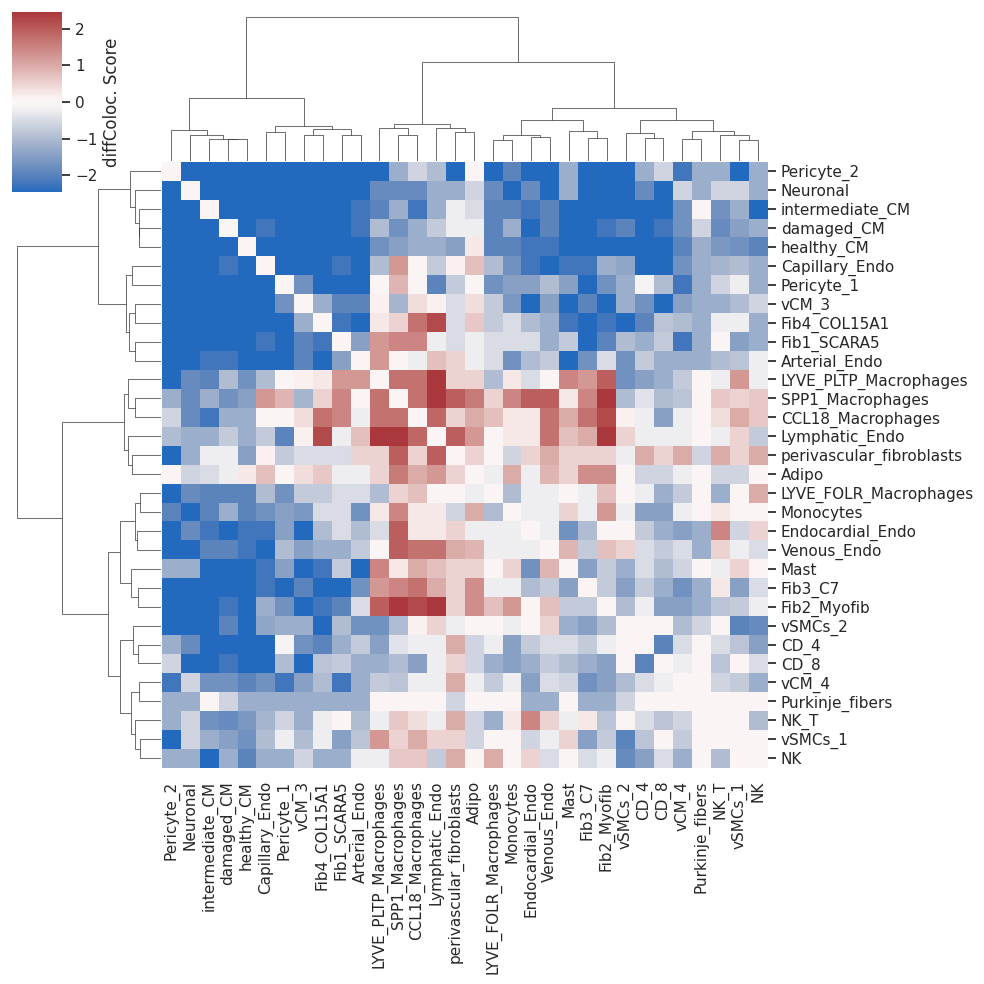

In [25]:
## Plot heatmap
sns.set(font_scale=1)
#plot=sns.clustermap(myo_isc_HM, cmap='vlag', center=0)
plot=sns.clustermap(myo_isc_HM, cmap='vlag', center=0, method='ward', cbar_kws={'label': 'diffColoc. Score'})

In [26]:
#### Clusters from clustermap on scores matrix
heatClusts=scipy.cluster.hierarchy.fcluster(plot.dendrogram_col.linkage, 1.9, depth=3)
nichesDF=pd.Series(heatClusts, index=plot.dendrogram_col.data.columns)
nichesDF

Fib1_SCARA5                 2
damaged_CM                  1
Capillary_Endo              2
LYVE_FOLR_Macrophages       4
Fib3_C7                     4
healthy_CM                  1
Fib2_Myofib                 4
Endocardial_Endo            4
Arterial_Endo               2
Neuronal                    1
Pericyte_1                  2
LYVE_PLTP_Macrophages       3
intermediate_CM             1
vCM_3                       2
Pericyte_2                  1
Mast                        4
Monocytes                   4
Fib4_COL15A1                2
SPP1_Macrophages            3
Venous_Endo                 4
vCM_4                       4
vSMCs_1                     4
CCL18_Macrophages           3
perivascular_fibroblasts    3
CD_4                        4
vSMCs_2                     4
Lymphatic_Endo              3
NK                          4
CD_8                        4
Purkinje_fibers             4
Adipo                       3
NK_T                        4
dtype: int32

Cell groups 

We can define different cell groups and visualise them with different colors in the colocalisation network

In [27]:
#parenchyme=['Adipo', 'damaged_CM', 'healthy_CM', 'intermediate_CM', 'vCM_3', 'vCM_4']
#immune=['CCL18_Macrophages', 'CD_4', 'CD_8', 'LYVE_FOLR_Macrophages', 'LYVE_PLTP_Macrophages', 'Mast', 'Monocytes', 'NK', 'NK_T', 'SPP1_Macrophages']
#stromal=['Arterial_Endo', 'Capillary_Endo', 'Endocardial_Endo', 'Fib3_C7', 'Fib4_COL15A1', 'Fib1_SCARA5', 'Lymphatic_Endo', 'Fib2_Myofib', 'Neuronal', 'Pericyte_1', 'Pericyte_2', 
#         'Purkinje_fibers', 'Venous_Endo', 'perivascular_fibroblasts', 'vSMCs_1', 'vSMCs_2']
#cellGroups={'parenchyme':parenchyme, 'stromal':stromal, 'immune':immune}

In [28]:
list(nichesDF.index[nichesDF==1])

['damaged_CM', 'healthy_CM', 'Neuronal', 'intermediate_CM', 'Pericyte_2']

In [29]:
niches_dict={'1_':list(nichesDF.index[nichesDF==1]),
     '2_':list(nichesDF.index[nichesDF==2]),
     '3_':list(nichesDF.index[nichesDF==3]),
     '4_':list(nichesDF.index[nichesDF==4]),
     '5_':list(nichesDF.index[nichesDF==5])       }
niches_dict

{'1_': ['damaged_CM',
  'healthy_CM',
  'Neuronal',
  'intermediate_CM',
  'Pericyte_2'],
 '2_': ['Fib1_SCARA5',
  'Capillary_Endo',
  'Arterial_Endo',
  'Pericyte_1',
  'vCM_3',
  'Fib4_COL15A1'],
 '3_': ['LYVE_PLTP_Macrophages',
  'SPP1_Macrophages',
  'CCL18_Macrophages',
  'perivascular_fibroblasts',
  'Lymphatic_Endo',
  'Adipo'],
 '4_': ['LYVE_FOLR_Macrophages',
  'Fib3_C7',
  'Fib2_Myofib',
  'Endocardial_Endo',
  'Mast',
  'Monocytes',
  'Venous_Endo',
  'vCM_4',
  'vSMCs_1',
  'CD_4',
  'vSMCs_2',
  'NK',
  'CD_8',
  'Purkinje_fibers',
  'NK_T'],
 '5_': []}

We will assign each niche a color to plot them later on

In [30]:
#Niches colors
cmap = plt.cm.get_cmap('tab10', 10)
clist=[mcolors.rgb2hex(cmap(i)[:3]) for i in [9]]
cmap = plt.cm.get_cmap('Set1', 9)
#clist=clist+[mcolors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
clist=clist+[mcolors.rgb2hex(cmap(i)[:3]) for i in [5,7,2,3]]
niche_cols=pd.Series(clist, index=['1_', '2_', '3_', '4_', '5_'])
niche_cols

1_    #17becf
2_    #ffff33
3_    #f781bf
4_    #4daf4a
5_    #984ea3
dtype: object

We will assign each cell its niche color as well

In [31]:
niches_df=nichesphere.tl.cells_niche_colors(CTs=CTprops.columns, niche_colors=niche_cols, niche_dict=niches_dict)
niches_df

,cell,niche,color
cell,,,
Fib1_SCARA5,Fib1_SCARA5,2_,#ffff33
damaged_CM,damaged_CM,1_,#17becf
Capillary_Endo,Capillary_Endo,2_,#ffff33
LYVE_FOLR_Macrophages,LYVE_FOLR_Macrophages,4_,#4daf4a
Fib3_C7,Fib3_C7,4_,#4daf4a
healthy_CM,healthy_CM,1_,#17becf
Fib2_Myofib,Fib2_Myofib,4_,#4daf4a
Endocardial_Endo,Endocardial_Endo,4_,#4daf4a
Arterial_Endo,Arterial_Endo,2_,#ffff33


Then we can have a nicer niches heatmap

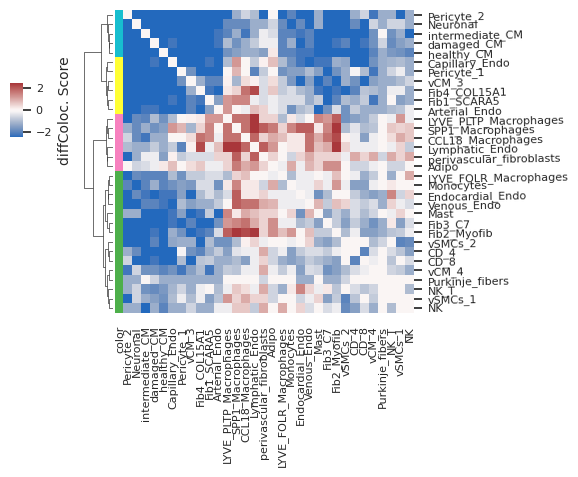

In [32]:
## Plot improved heatmap
sns.set(font_scale=1)
plot=sns.clustermap(myo_isc_HM, cmap='vlag', center=0, method='ward', cbar_kws={'label': 'diffColoc. Score'}, row_colors=niches_df.color)

hm = plot.ax_heatmap.get_position()
plt.setp(plot.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10)
plt.setp(plot.ax_heatmap.xaxis.get_majorticklabels(), fontsize=10)

## heatmap position
plot.ax_heatmap.set_position([hm.x0, hm.y0, hm.width*0.5, hm.height*0.5])
col = plot.ax_col_dendrogram.get_position()
## dendrograms position
plot.ax_col_dendrogram.set_position([col.x0, col.y0*0.58, col.width*0.5, col.height*0.25])
row = plot.ax_row_dendrogram.get_position()
plot.ax_row_dendrogram.set_position([row.x0*8.5, row.y0, row.width*0.2, row.height*0.5])
## colorbar position
x0, y0, w, h = plot.cbar_pos
plot.ax_cbar.set_position([x0*4, y0*0.5, w*0.25, h*0.3])
plot.figure.axes[-1].yaxis.label.set_size(10)

## row_colors position
box = plot.ax_row_colors.get_position()
plot.ax_row_colors.set_position([box.x0+0.015, box.y0, box.width*0.5, box.height*0.5])
plot.ax_cbar.tick_params(labelsize=10)
plot.tick_params(labelsize=8)
#plot.cbar_kws(labelsize=10)

plt.setp(plot.ax_heatmap.yaxis.get_majorticklabels(), rotation=1)
#plt.savefig('../../../../figures_nichesphere_tutorial/OvsE_TPO_clustered.pdf')
plt.show()

In [33]:
#### Filter test HM
p=0.05
myo_isc_HM=myo_iscDF.statistic.copy()

myo_isc_HM[myo_iscDF['p-value']>p]=0
myo_isc_HM[oneCTints]=0
# Reshape into data frame
myo_isc_HM=pd.DataFrame(np.array(myo_isc_HM).reshape(-1, len(CTprops.columns)))
myo_isc_HM.columns=CTprops.columns
myo_isc_HM.index=CTprops.columns
myo_isc_HM=myo_isc_HM.apply(pd.to_numeric)
## No prolif cells
myo_isc_HM=myo_isc_HM.loc[myo_isc_HM.columns.str.contains('prolif')==False,myo_isc_HM.index.str.contains('prolif')==False]

In [34]:
myo_isc_HM=myo_isc_HM.loc[myo_isc_HM.sum()!=0,myo_isc_HM.sum()!=0]
myo_isc_HM=myo_isc_HM.loc[(myo_isc_HM!=0).sum()>1,(myo_isc_HM!=0).sum()>1]

In [35]:
(myo_isc_HM!=0).sum()

Fib1_SCARA5         10
damaged_CM          16
Capillary_Endo      16
Fib3_C7              9
healthy_CM          18
Fib2_Myofib          9
Endocardial_Endo     6
Arterial_Endo        9
Neuronal            15
Pericyte_1          11
intermediate_CM     17
vCM_3               10
Pericyte_2          16
Mast                 7
Fib4_COL15A1        14
SPP1_Macrophages     2
Venous_Endo          4
vCM_4                3
CD_4                 4
vSMCs_2              5
Lymphatic_Endo       3
CD_8                 6
dtype: int64

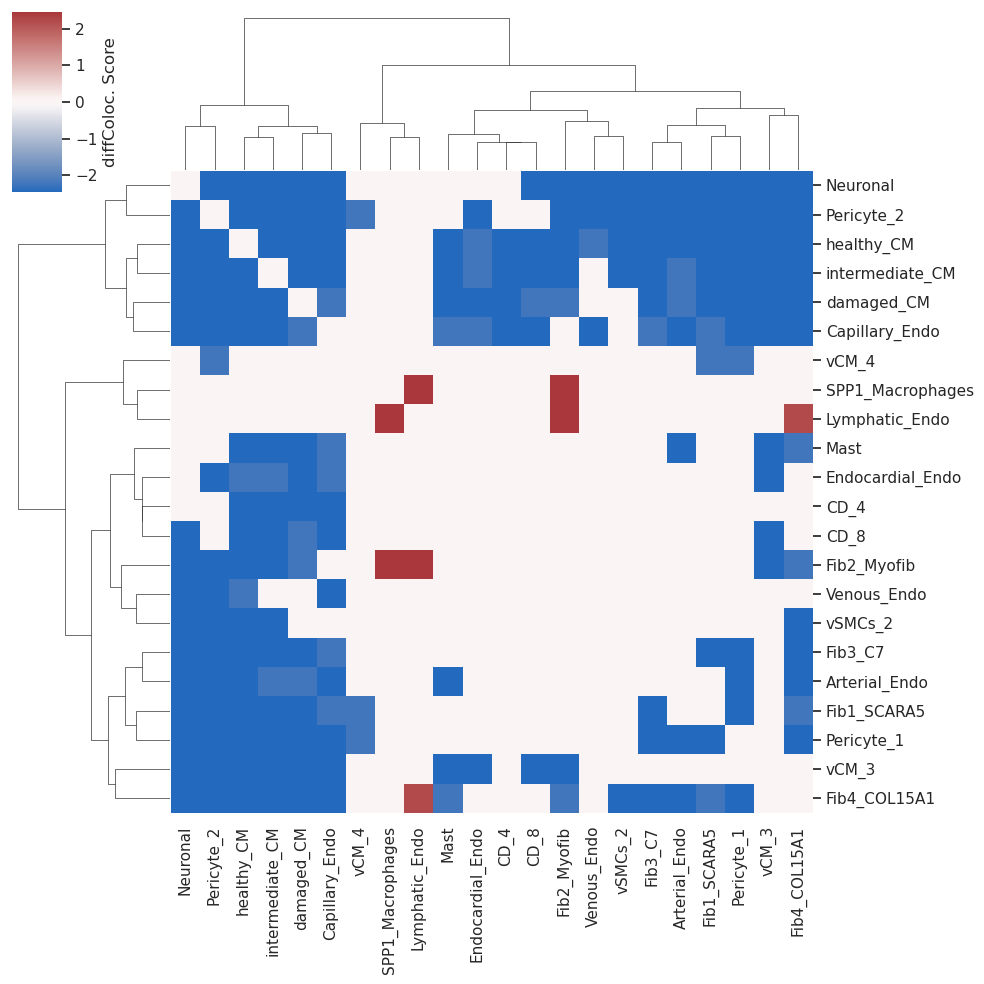

In [39]:
## Plot heatmap
sns.set(font_scale=1)
#plot=sns.clustermap(myo_isc_HM, cmap='vlag', center=0)
plot=sns.clustermap(myo_isc_HM, cmap='vlag', center=0, method='ward', cbar_kws={'label': 'diffColoc. Score'})

Differential co-localization network

To build the differential co-localization network, we will get an adjacency matrix (adj) based on the cosine similarities of the distributions of significant differential co-localization scores for the different cell types

In [40]:
##Cosine similarity plus pseudocount
adj=pd.DataFrame(sklearn.metrics.pairwise.cosine_similarity(myo_isc_HM)+1)
adj.index=myo_isc_HM.index
adj.columns=myo_isc_HM.columns

##Cell pairs with not significant differential co-localization get 0
adj[myo_isc_HM==0]=0
adj[adj==1]=0

clistThen the network is built just taking into account the differentially co-localized cell type pairs. The cell groups dictionary can be used here to visualize different cell groups in different colors.

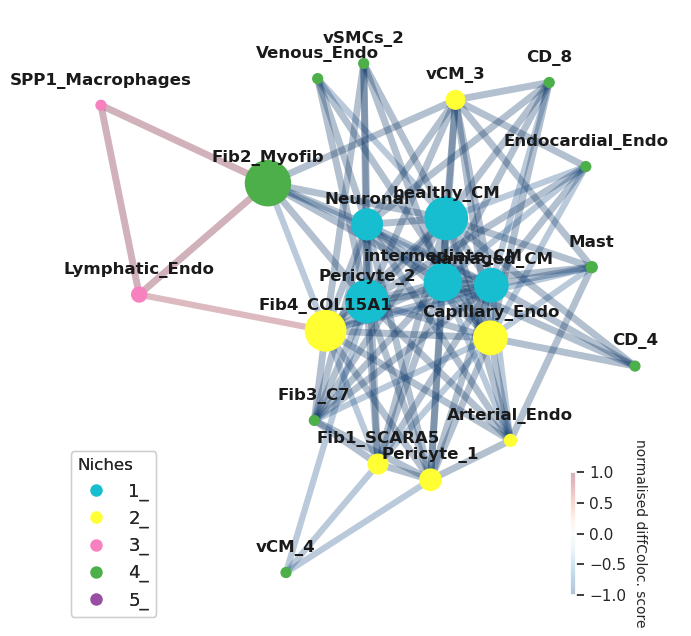

In [42]:
plt.rcParams['axes.facecolor'] = "None"
gCol=nichesphere.tl.colocNW(x_diff=myo_isc_HM, adj=adj,cell_group=niches_dict, clist=clist, BTsizedNodes=True)

weights=nx.get_edge_attributes(gCol,'weight').values()

legend_elements1 = [plt.Line2D([0], [0], marker="o" ,color='w', markerfacecolor=plt.cm.tab10.colors[9], lw=4, label='1_', ms=10),
                    plt.Line2D([0], [0], marker="o" ,color='w', markerfacecolor=plt.cm.Set1.colors[5], lw=4, label='2_', ms=10),
                   plt.Line2D([0], [0], marker="o" ,color='w', markerfacecolor=plt.cm.Set1.colors[7], lw=4, label='3_', ms=10),
                   plt.Line2D([0], [0], marker="o" ,color='w', markerfacecolor=plt.cm.Set1.colors[2], lw=4, label='4_', ms=10),
                   plt.Line2D([0], [0], marker="o" ,color='w', markerfacecolor=plt.cm.Set1.colors[3], lw=4, label='5_', ms=10)]

plt.gca().add_artist(plt.legend(handles=legend_elements1,loc='lower left', fontsize=13, title='Niches', alignment='left'))
#with plt.rc_context({'image.composite_image': False}):
#    plt.savefig('../../../../figures_nichesphere_tutorial/diffColocNW_TPO_4adjClusts.pdf', format="pdf", bbox_inches="tight")

We can then calculate some network statistics with the networkX package [ref] functions:

In [43]:
t1=pd.DataFrame({'influencer':[nx.eigenvector_centrality(gCol)[x] for x in list(gCol.nodes)], 'betweenness':[nx.betweenness_centrality(gCol)[x] for x in list(gCol.nodes)], 
                 'degree':[nx.degree_centrality(gCol)[x] for x in list(gCol.nodes)], 'pagerank':[nx.pagerank(gCol, weight=None)[x] for x in list(gCol.nodes)]})
t1.index=list(gCol.nodes)

And visualize them

Text(0.5, 1.0, 'Betweenness')

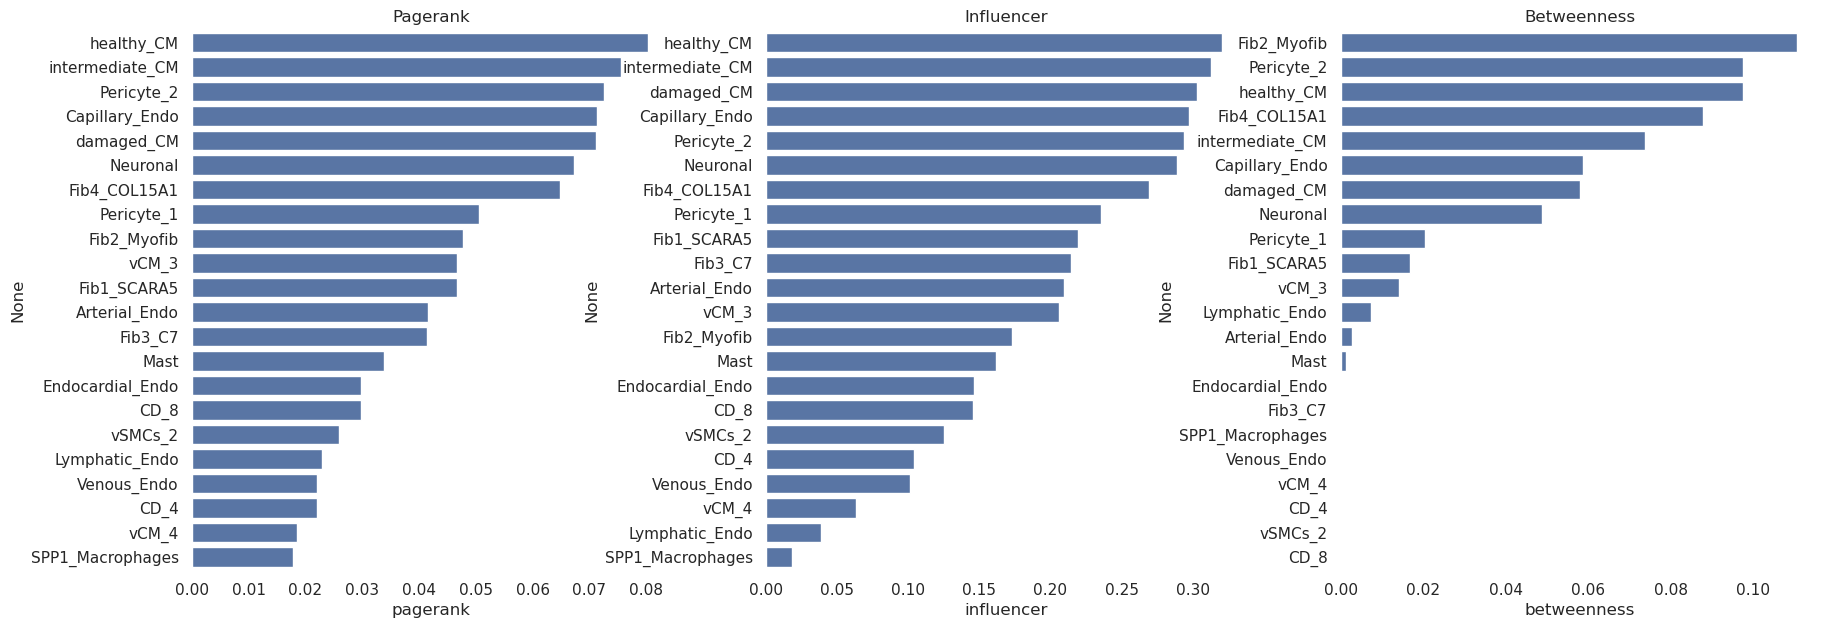

In [44]:

fig, axes = plt.subplots(1, 3, figsize=(21, 7))
sns.barplot(ax=axes[0], y=t1.sort_values('pagerank', ascending=False).index, x='pagerank', data=t1.sort_values('pagerank', ascending=False))
axes[0].set_title('Pagerank')
sns.barplot(ax=axes[1], y=t1.sort_values('influencer', ascending=False).index, x='influencer', data=t1.sort_values('influencer', ascending=False))
axes[1].set_title('Influencer')
sns.barplot(ax=axes[2], y=t1.sort_values('betweenness', ascending=False).index, x='betweenness', data=t1.sort_values('betweenness', ascending=False))
axes[2].set_title('Betweenness')
#plt.savefig('../../../../figures_nichesphere_tutorial/diffColocNW_stats.pdf')

## **Process based localized differential communication**

One of the advantages of Nichesphere is that it allows process based localized differential communication testing by looking at changes in LR interactions involved in specific processes between niches. To do this, we will first assign each cell type pair its corresponding niche pair:

In [45]:
pairCatDFdir=nichesphere.tl.get_pairCatDFdir(niches_dict, CTcolocalizationP, niches_df.niche)
pairCatDFdir

,cell_pairs,niche_pairs
0,Fib1_SCARA5->Fib1_SCARA5,2_->2_
1,Fib1_SCARA5->damaged_CM,2_->1_
2,Fib1_SCARA5->Capillary_Endo,2_->2_
3,Fib1_SCARA5->LYVE_FOLR_Macrophages,2_->4_
4,Fib1_SCARA5->Fib3_C7,2_->4_
...,...,...
1084,NK_T->NK,4_->4_
1085,NK_T->CD_8,4_->4_
1086,NK_T->Purkinje_fibers,4_->4_
1087,NK_T->Adipo,4_->3_


In [46]:
## Filter by colocalization

pairCatDF_filter=[(pairCatDFdir.cell_pairs.str.split('->')[i][0] in adj.index)&(pairCatDFdir.cell_pairs.str.split('->')[i][1] in adj.index) for i in pairCatDFdir.index]
pairCatDFdir_filt=pairCatDFdir[pairCatDF_filter]

In [47]:
oneCTints_filt=oneCTints[[i.split('-')[0] in adj.index for i in oneCTints]]


We will also filter cell type pairs with non significant differential co-localization scores. Cell pairs with filter=1 will be tested

In [48]:
## To filter communication data (network)
colocFilt=nichesphere.tl.getColocFilter(pairCatDF=pairCatDFdir_filt, adj=adj, oneCTints=oneCTints_filt.str.replace('-', '->'))
colocFilt

,filter
cell_pairs,
Fib1_SCARA5->Fib1_SCARA5,1.0
Fib1_SCARA5->damaged_CM,1.0
Fib1_SCARA5->Capillary_Endo,1.0
Fib1_SCARA5->Fib3_C7,1.0
Fib1_SCARA5->healthy_CM,1.0
...,...
CD_8->vCM_4,0.0
CD_8->CD_4,0.0
CD_8->vSMCs_2,0.0


Get cell communication data (CrossTalkeR tables)

In [49]:
crossTalker_ctrlComm=pd.read_csv('./crossTalker_tbl_myo_heart_exp_scSeqComm.csv', index_col=0)
crossTalker_iscComm=pd.read_csv('./crossTalker_tbl_isc_heart_exp_scSeqComm.csv', index_col=0)

In [50]:
#crossTalker_ctrlComm=crossTalker_ctrlComm.replace({'Fib_0': 'Fib3_C7', 'Fib_3': 'Fib4_COL15A1', "Myofib": "Fib2_Myofib", "Fib_SCARA5":"Fib1_SCARA5", 'CD4': 'CD_4', 'CD8': 'CD_8'}, regex=True)

In [51]:
#crossTalker_iscComm=crossTalker_iscComm.replace({'Fib_0': 'Fib3_C7', 'Fib_3': 'Fib4_COL15A1', "Myofib": "Fib2_Myofib", "Fib_SCARA5":"Fib1_SCARA5", 'CD4': 'CD_4', 'CD8': 'CD_8'}, regex=True)

Nichesphere is suited to work with CrossTalkeR output tables which contain columns called **cellpair**, indicating the cell types involved in an interaction separated by '@'; and **allpair**, indicating cell types, ligand and receptor involved. Additionally, input tables for Nichesphere should contain columns indicating the **ligand** (gene_A), **receptor** (gene_B) and **communication score** (MeanLR). The names for these last 3 columns can be indicated in Nichesphere functions.

CrossTalkeR tables contain strings indicating wether a gene is a ligand (|L), receptor (|R) or transcription factor (|TF). These strings will be removed as they might cause conflicts with code. 

In [52]:
crossTalker_ctrlComm=nichesphere.tl.processCTKRoutput(crossTalker_ctrlComm)
crossTalker_iscComm=nichesphere.tl.processCTKRoutput(crossTalker_iscComm)

Names of cell types need to match between communication and colocalisation data

In [53]:
crossTalker_ctrlComm

,ligand,receptor_complex,cellpair,source,target,inter_score,type_gene_A,type_gene_B,gene_A,gene_B,MeanLR,allpair,ligpair,recpair,LRScore,LRmean,LRprod,LRscSeqComm
1,A2M,LRP1,Adipo@Adipo,Adipo,Adipo,0.742349,Ligand,Receptor,A2M,LRP1,0.742349,Adipo/A2M@Adipo/LRP1,Adipo/A2M|L,Adipo/LRP1|R,0.742349,0.403849,0.066025,0.742349
2,ADAM10,EPHA3,Adipo@Adipo,Adipo,Adipo,0.937603,Ligand,Receptor,ADAM10,EPHA3,0.937603,Adipo/ADAM10@Adipo/EPHA3,Adipo/ADAM10|L,Adipo/EPHA3|R,0.937603,0.207537,0.038841,0.937603
3,ADAM12,ITGA9,Adipo@Adipo,Adipo,Adipo,0.964709,Ligand,Receptor,ADAM12,ITGA9,0.964709,Adipo/ADAM12@Adipo/ITGA9,Adipo/ADAM12|L,Adipo/ITGA9|R,0.964709,0.272629,0.061187,0.964709
4,ADAM12,ITGB1,Adipo@Adipo,Adipo,Adipo,0.999963,Ligand,Receptor,ADAM12,ITGB1,0.999963,Adipo/ADAM12@Adipo/ITGB1,Adipo/ADAM12|L,Adipo/ITGB1|R,0.999963,0.333766,0.108538,0.999963
5,ADAM17,ITGB1,Adipo@Adipo,Adipo,Adipo,0.999963,Ligand,Receptor,ADAM17,ITGB1,0.999963,Adipo/ADAM17@Adipo/ITGB1,Adipo/ADAM17|L,Adipo/ITGB1|R,0.999963,0.309172,0.094752,0.999963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217519,VEGFA,NRP1,vSMCs_2@vSMCs_2,vSMCs_2,vSMCs_2,0.989853,Ligand,Receptor,VEGFA,NRP1,0.989853,vSMCs_2/VEGFA@vSMCs_2/NRP1,vSMCs_2/VEGFA|L,vSMCs_2/NRP1|R,0.989853,0.501278,0.084379,0.989853
217520,VEGFB,FLT1,vSMCs_2@vSMCs_2,vSMCs_2,vSMCs_2,0.965057,Ligand,Receptor,VEGFB,FLT1,0.965057,vSMCs_2/VEGFB@vSMCs_2/FLT1,vSMCs_2/VEGFB|L,vSMCs_2/FLT1|R,0.965057,0.102204,0.010095,0.965057
217521,VEGFB,NRP1,vSMCs_2@vSMCs_2,vSMCs_2,vSMCs_2,0.999945,Ligand,Receptor,VEGFB,NRP1,0.999945,vSMCs_2/VEGFB@vSMCs_2/NRP1,vSMCs_2/VEGFB|L,vSMCs_2/NRP1|R,0.999945,0.515369,0.110020,0.999945
217522,VIM,CD44,vSMCs_2@vSMCs_2,vSMCs_2,vSMCs_2,0.627537,Ligand,Receptor,VIM,CD44,0.627537,vSMCs_2/VIM@vSMCs_2/CD44,vSMCs_2/VIM|L,vSMCs_2/CD44|R,0.627537,0.252344,0.025276,0.627537


In [54]:
allDBs=pd.read_csv('../../nichesphere_tutorial_data/allDBs.csv', index_col=0)
allDBs['Ligand']=allDBs['Ligand'].str.lower()
allDBs

,Ligand,category,db,ensembl_gene_id,iname,synonyms,description
2,col1a1,Collagens,matrissome,NaN,NaN,NaN,NaN
5,col1a2,Collagens,matrissome,NaN,NaN,NaN,NaN
17,col6a3,Collagens,matrissome,NaN,NaN,NaN,NaN
23,col3a1,Collagens,matrissome,NaN,NaN,NaN,NaN
30,col2a1,Collagens,matrissome,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
125,pmaip1,apoptosis,deathbase,ENSDARG00000071431,Zebrafish,phorbol-12-myristate-13-acetate-induced protei...,phorbol-12-myristate-13-acetate-induced protei...
126,tnfrsfa,apoptosis,deathbase,ENSDARG00000004451,Zebrafish,tumor necrosis factor receptor superfamily mem...,"tumor necrosis factor receptor superfamily, me..."
127,tnfsf10l,apoptosis,deathbase,ENSDARG00000004196,Zebrafish,tumor necrosis factor (ligand) superfamily mem...,"tumor necrosis factor (ligand) superfamily, me..."
128,tnfsf10l2,apoptosis,deathbase,ENSDARG00000057241,Zebrafish,tumor necrosis factor (ligand) superfamily mem...,"tumor necrosis factor (ligand) superfamily, me..."


Then we'll separate communication scores by process to know which cell type pairs and niche pairs are interacting through which processes in each condition.

In [55]:
myoCTpairScores_byCat2_dir_colocClusts=nichesphere.tl.lr_ctPairScores_perCat_dir(ccommTable=crossTalker_ctrlComm, db=allDBs, dbCatCol='category', dbMatchCol='Ligand', 
                        ccommMatchCol='gene_A', ccommLRscoresCol='MeanLR', oneCTinteractions=oneCTints.str.replace('-', '@'), condition='myogenic', pairCatDF=pairCatDFdir)

In [56]:
iscCTpairScores_byCat2_dir_colocClusts=nichesphere.tl.lr_ctPairScores_perCat_dir(ccommTable=crossTalker_iscComm, db=allDBs, dbCatCol='category', dbMatchCol='Ligand', 
                        ccommMatchCol='gene_A', ccommLRscoresCol='MeanLR', oneCTinteractions=oneCTints.str.replace('-', '@'), condition='ischemic', pairCatDF=pairCatDFdir)

In [57]:
myoCTpairScores_byCat2_dir_colocClusts

,cell_pairs,niche_pairs,LRscores,LRcat,condition
allpair,,,,,
Adipo/COL14A1@Arterial_Endo/CD44,Adipo->Arterial_Endo,3_->2_,0.717175,Collagens,myogenic
Adipo/COL14A1@CCL18_Macrophages/CD44,Adipo->CCL18_Macrophages,3_->3_,0.967985,Collagens,myogenic
Adipo/COL14A1@CD_4/CD44,Adipo->CD_4,3_->4_,0.967985,Collagens,myogenic
Adipo/COL14A1@CD_8/CD44,Adipo->CD_8,3_->4_,0.967985,Collagens,myogenic
Adipo/COL14A1@Fib1_SCARA5/CD44,Adipo->Fib1_SCARA5,3_->2_,0.967985,Collagens,myogenic
...,...,...,...,...,...
Venous_Endo/TNFSF10@damaged_CM/TNFRSF11B,Venous_Endo->damaged_CM,4_->1_,0.995297,apoptosis,myogenic
Venous_Endo/TNFSF10@prolif/TNFRSF10B,Venous_Endo->prolif,4_->4_,0.999923,apoptosis,myogenic
Venous_Endo/TNFSF10@prolif/TNFRSF10D,Venous_Endo->prolif,4_->4_,0.999857,apoptosis,myogenic


Some interactions might be present only in one condition, so we will assign 0 values to the interactions that do not appear in one condition to be able to compare conditions

In [58]:
myoCTpairScores_byCat2_dir_colocClusts, iscCTpairScores_byCat2_dir_colocClusts = nichesphere.tl.equalizeScoresTables(ctrlTbl=myoCTpairScores_byCat2_dir_colocClusts, 
                                                    expTbl=iscCTpairScores_byCat2_dir_colocClusts, ctrlCondition='myogenic', expCondition='ischemic')

Filter by co-localization

In [59]:
myoCTpairScores_byCat2_dir_colocClusts=myoCTpairScores_byCat2_dir_colocClusts[[i in colocFilt.index[colocFilt['filter']==1] for i in myoCTpairScores_byCat2_dir_colocClusts.cell_pairs]]
iscCTpairScores_byCat2_dir_colocClusts=iscCTpairScores_byCat2_dir_colocClusts[[i in colocFilt.index[colocFilt['filter']==1] for i in iscCTpairScores_byCat2_dir_colocClusts.cell_pairs]]

Then we can test for differential cell cell communication between niche pairs or cell pairs across processes with the function 'tl.diffCcommStats'. We will first test per niche pair setting the parameter 'cellCatCol' to 'niche_pairs', which is the column in the tables of communication scores by process containing niche pairs:

In [60]:
## Differential communication statistics
myoIsc_diffCcommTable_colocGroups_dir=nichesphere.tl.diffCcommStats(c1CTpairScores_byCat=iscCTpairScores_byCat2_dir_colocClusts, c2CTpairScores_byCat=myoCTpairScores_byCat2_dir_colocClusts, cellCatCol='niche_pairs')


In [61]:
niches_dict

{'1_': ['damaged_CM',
  'healthy_CM',
  'Neuronal',
  'intermediate_CM',
  'Pericyte_2'],
 '2_': ['Fib1_SCARA5',
  'Capillary_Endo',
  'Arterial_Endo',
  'Pericyte_1',
  'vCM_3',
  'Fib4_COL15A1'],
 '3_': ['LYVE_PLTP_Macrophages',
  'SPP1_Macrophages',
  'CCL18_Macrophages',
  'perivascular_fibroblasts',
  'Lymphatic_Endo',
  'Adipo'],
 '4_': ['LYVE_FOLR_Macrophages',
  'Fib3_C7',
  'Fib2_Myofib',
  'Endocardial_Endo',
  'Mast',
  'Monocytes',
  'Venous_Endo',
  'vCM_4',
  'vSMCs_1',
  'CD_4',
  'vSMCs_2',
  'NK',
  'CD_8',
  'Purkinje_fibers',
  'NK_T'],
 '5_': []}

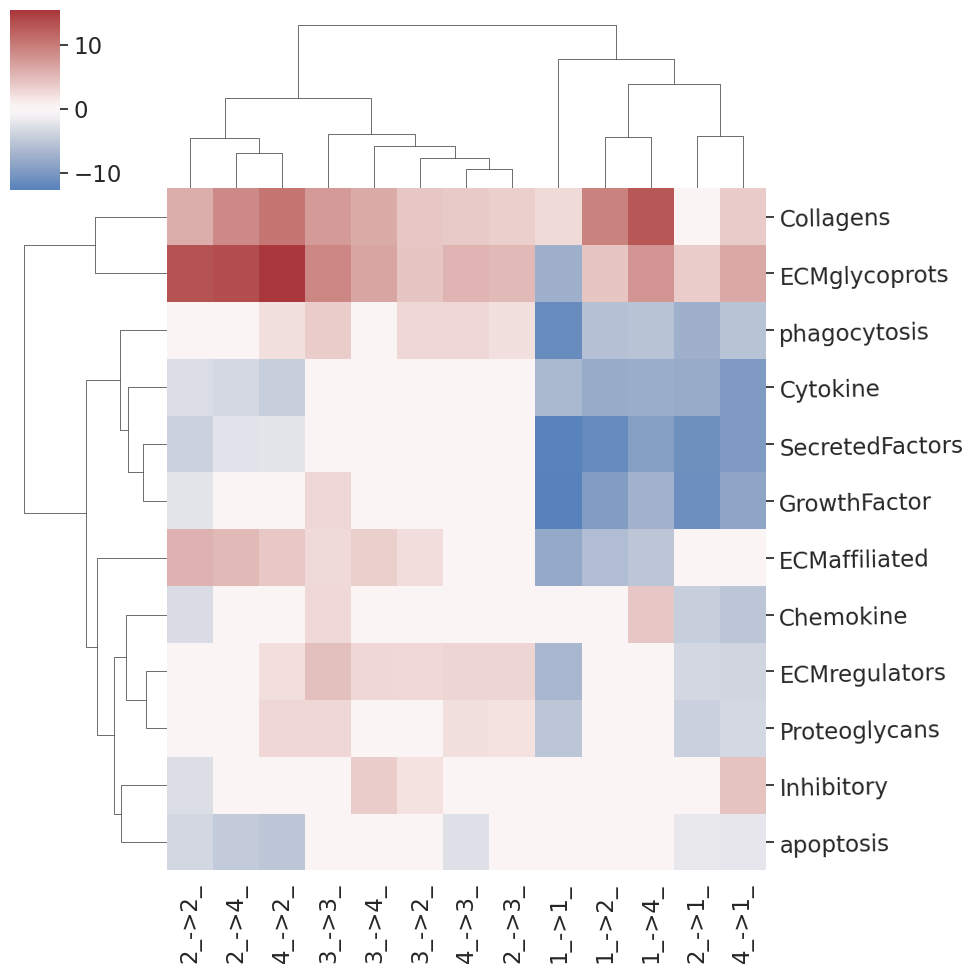

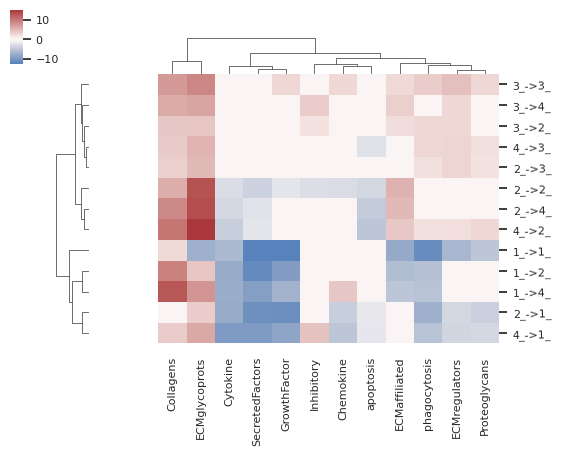

In [62]:
## Differential communication by coloc group

## Plot in heatmap
hm_df, cm=nichesphere.tl.plotDiffCcommStatsHM(diffCommTable=myoIsc_diffCcommTable_colocGroups_dir, min_pval=0.05)

cm=sns.clustermap(hm_df.T, cmap='vlag', center=0, method='complete')
#plot.set_yticklabels(rotation=90)
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=1)

hm = cm.ax_heatmap.get_position()
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), fontsize=8)
plt.setp(cm.ax_heatmap.xaxis.get_majorticklabels(), fontsize=8)

## heatmap position
cm.ax_heatmap.set_position([hm.x0, hm.y0, hm.width*0.5, hm.height*0.45])
col = cm.ax_col_dendrogram.get_position()
## dendrograms position
cm.ax_col_dendrogram.set_position([col.x0, col.y0*0.6, col.width*0.5, col.height*0.25])
row = cm.ax_row_dendrogram.get_position()
cm.ax_row_dendrogram.set_position([row.x0*3.5, row.y0, row.width*0.2, row.height*0.45])
## colorbar position
x0, y0, w, h = cm.cbar_pos
cm.ax_cbar.set_position([x0*2.5, y0*0.63, w*0.25, h*0.3])
cm.tick_params(labelsize=8)


#plt.savefig('./figures/colocFiltereddiffComm_colocClusts_categories_4clusts.pdf')
#plt.savefig('../../../../figures_nichesphere_tutorial/colocFiltereddiffComm_colocClusts_categories_4clusts_phagocyt_death.pdf')

plt.show()

Then we'll calculate communication scores summing scores for a specific LR pair for a specific cell type pair and separate these scores per ligand category to know which cell type pairs are interacting through which mechanisms.

Localized differential communication networks

To build process specific differential cell communication networks, we will look at differential cell communication per cell type pair per process, so we will do the differential communication test again, this time setting 'cellCatCol' to 'cell_pairs', which is the column in the tables of communication scores by process containing cell pairs

In [63]:
## Differential cell communication per cell type pair

## Differential communication statistics
myoIsc_diffCcommTable2_CTpair_dir=nichesphere.tl.diffCcommStats(c1CTpairScores_byCat=iscCTpairScores_byCat2_dir_colocClusts, c2CTpairScores_byCat=myoCTpairScores_byCat2_dir_colocClusts, cellCatCol='cell_pairs')


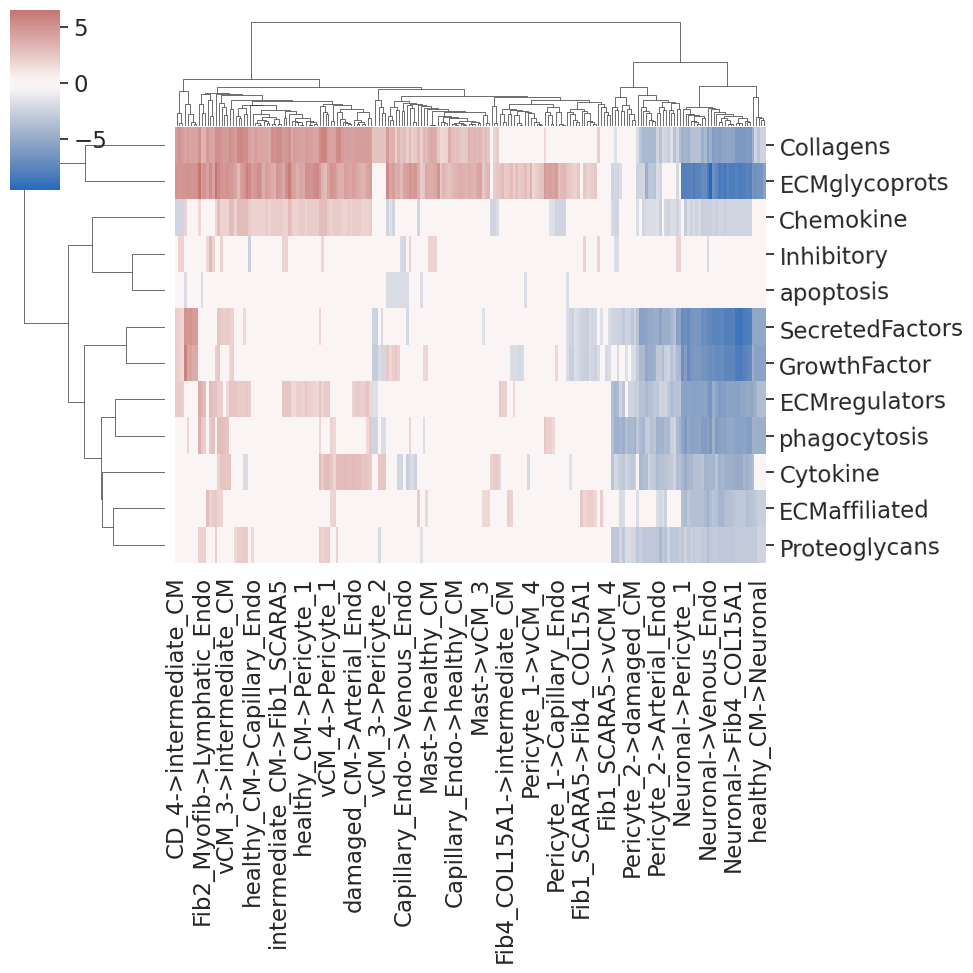

In [64]:
x_myoIsc_dir, plothm=nichesphere.tl.plotDiffCcommStatsHM(diffCommTable=myoIsc_diffCcommTable2_CTpair_dir, min_pval=0.1)

Now we can plot differential cell communication scores per process on the co-localization network

<Figure size 640x480 with 0 Axes>

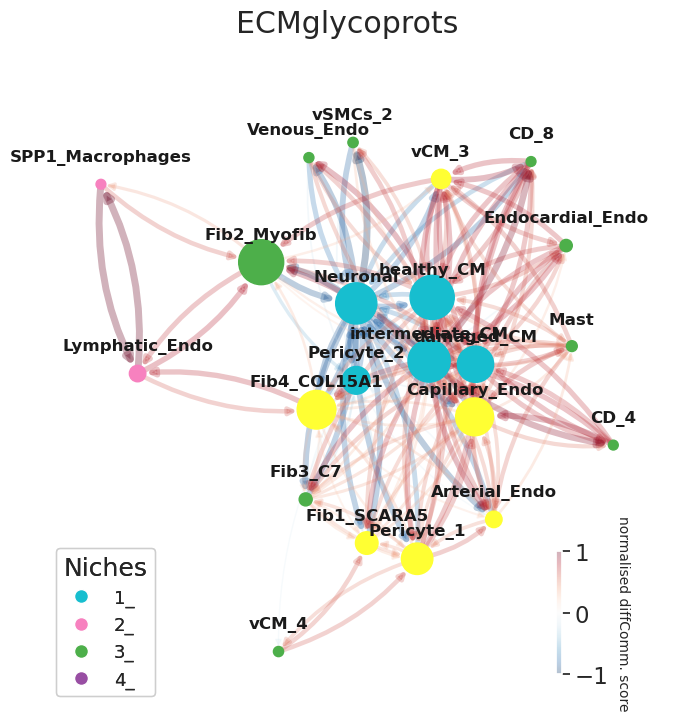

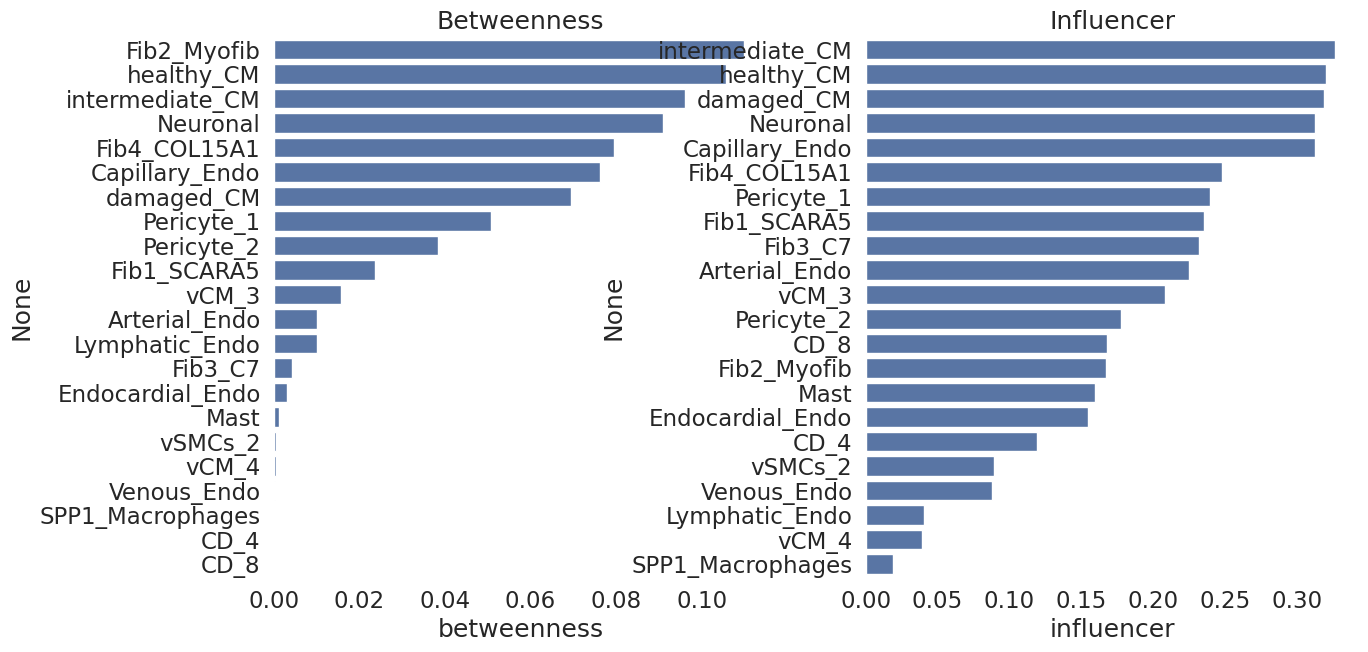

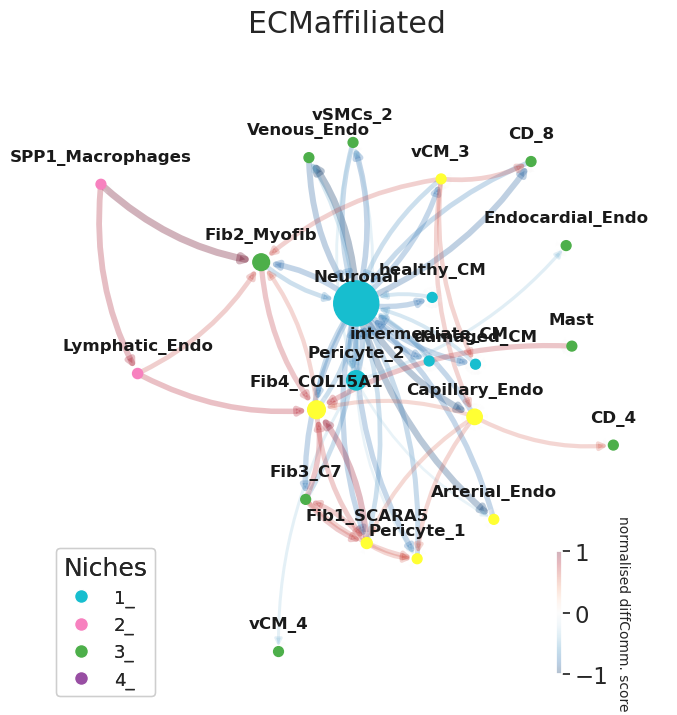

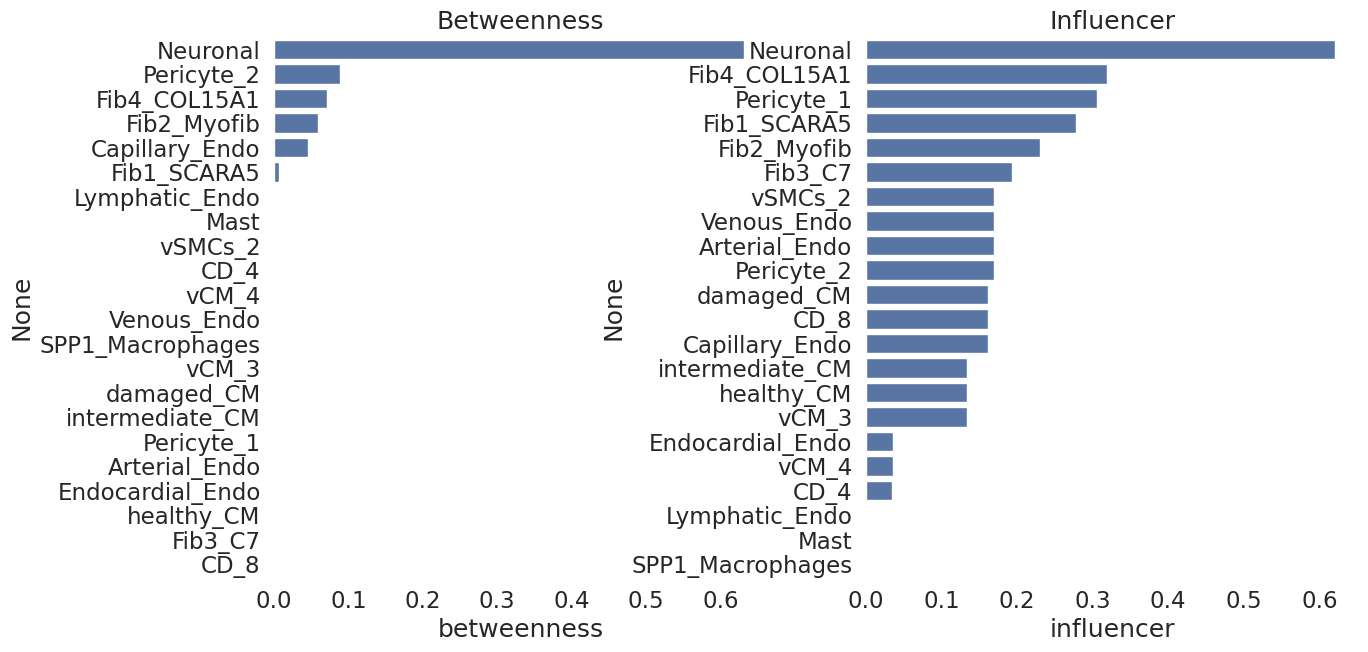

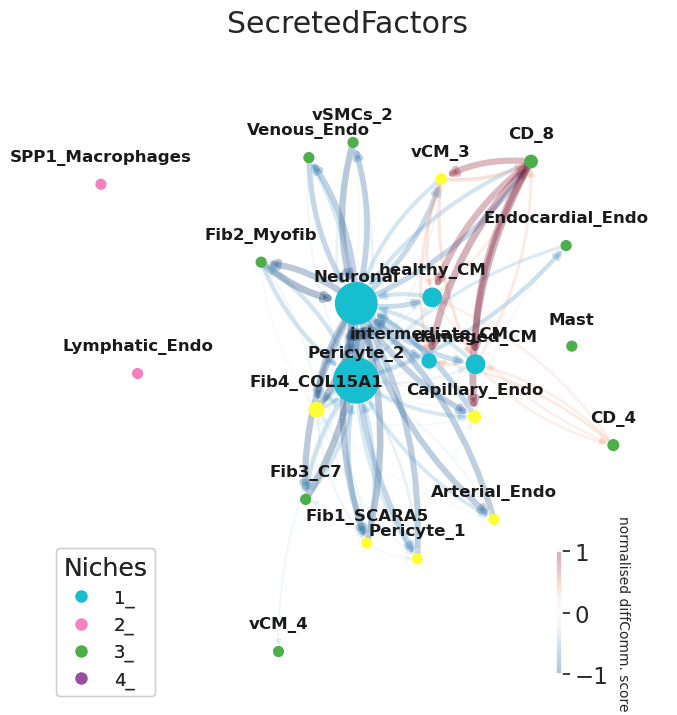

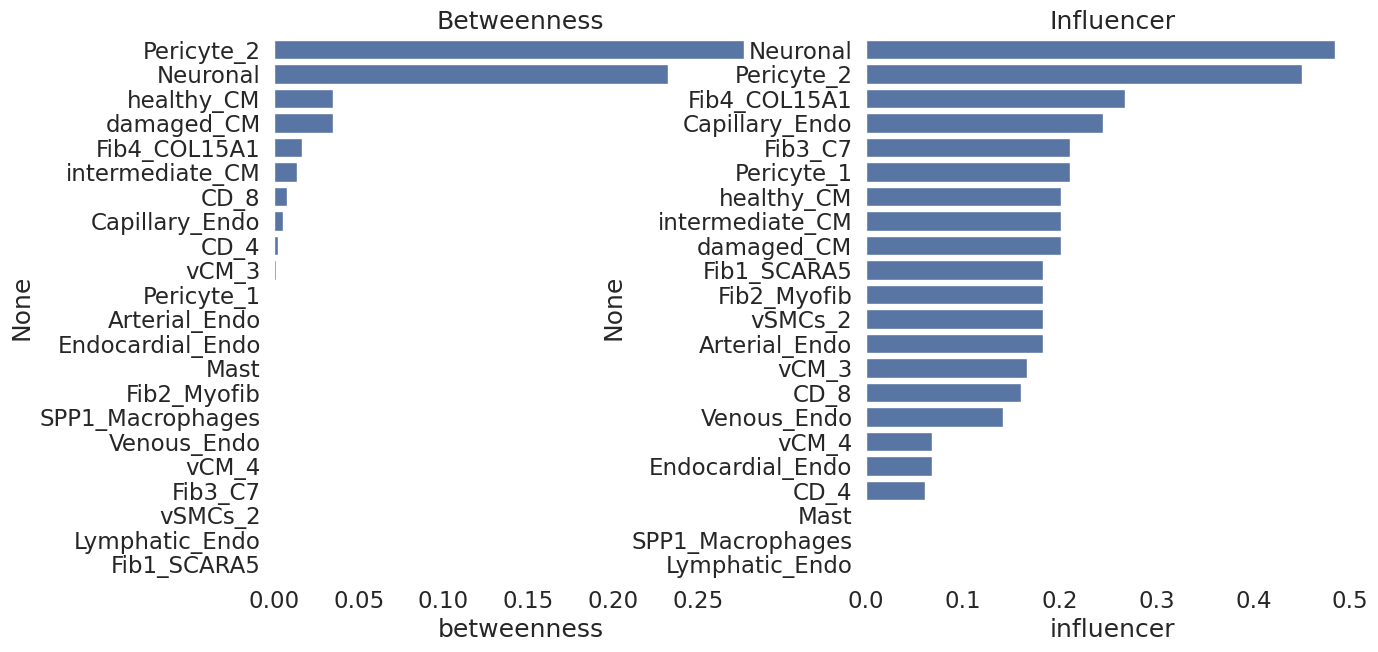

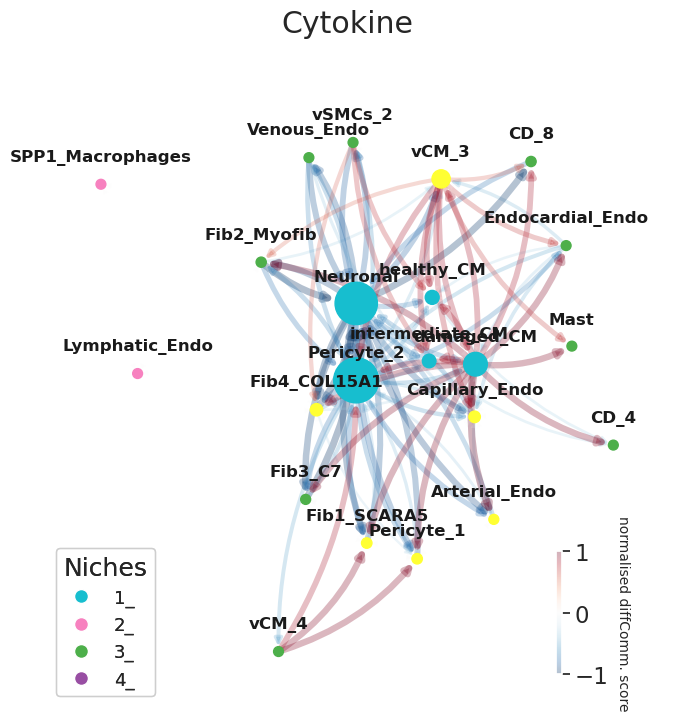

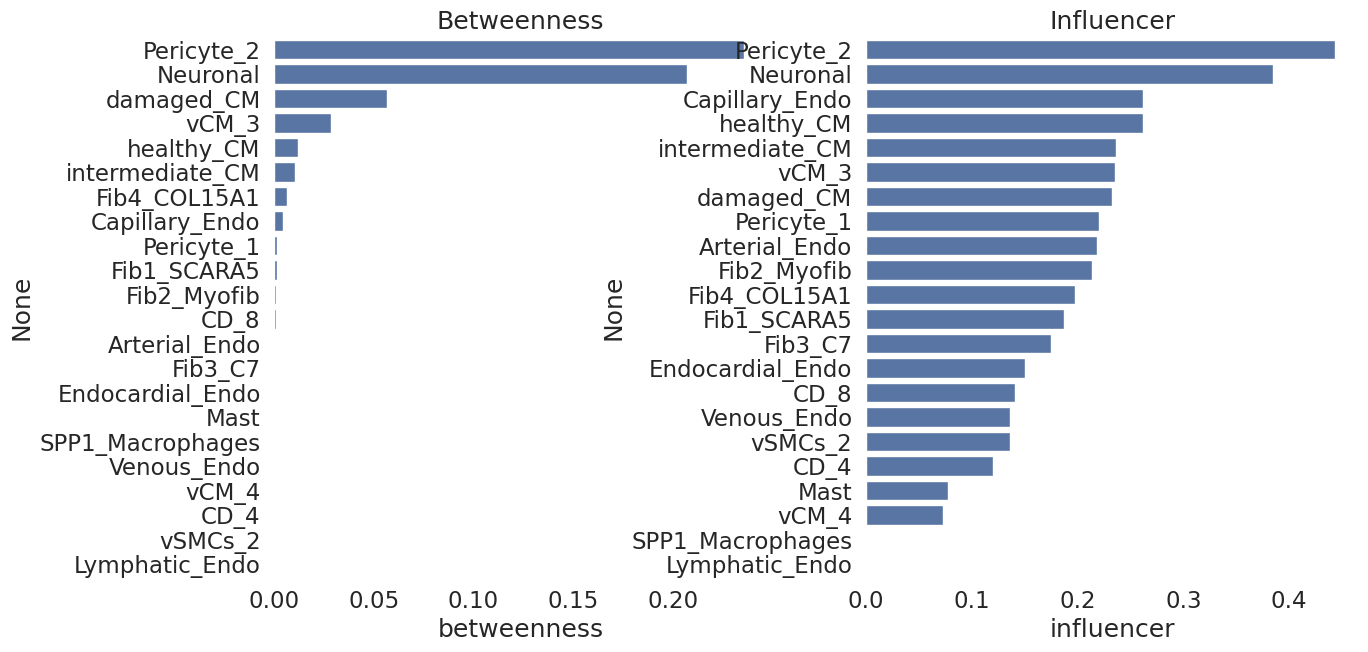

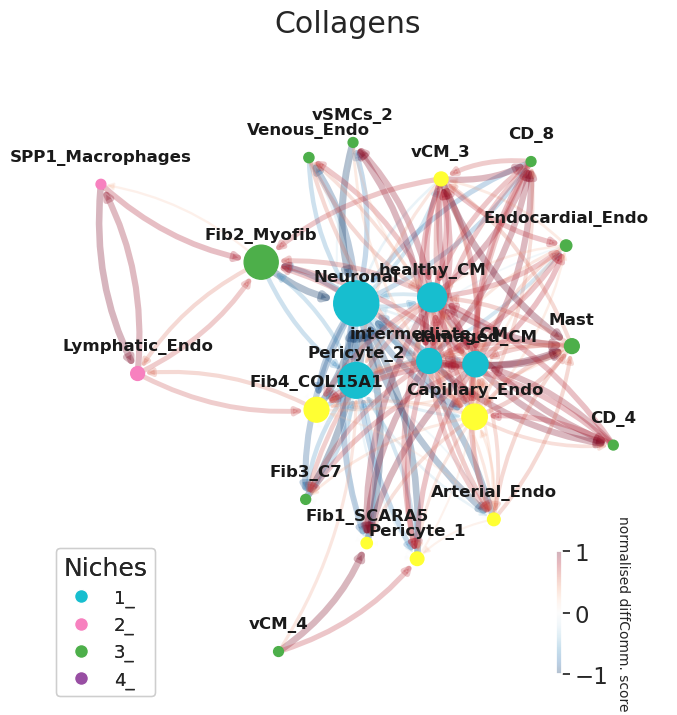

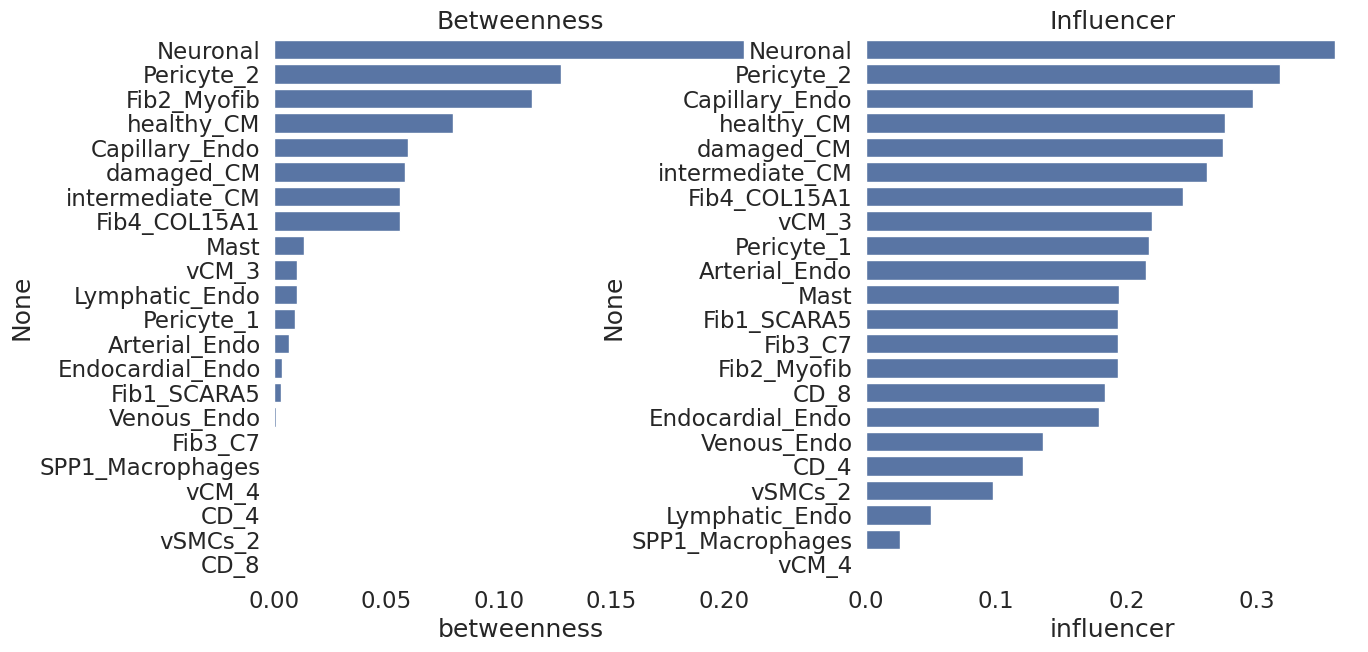

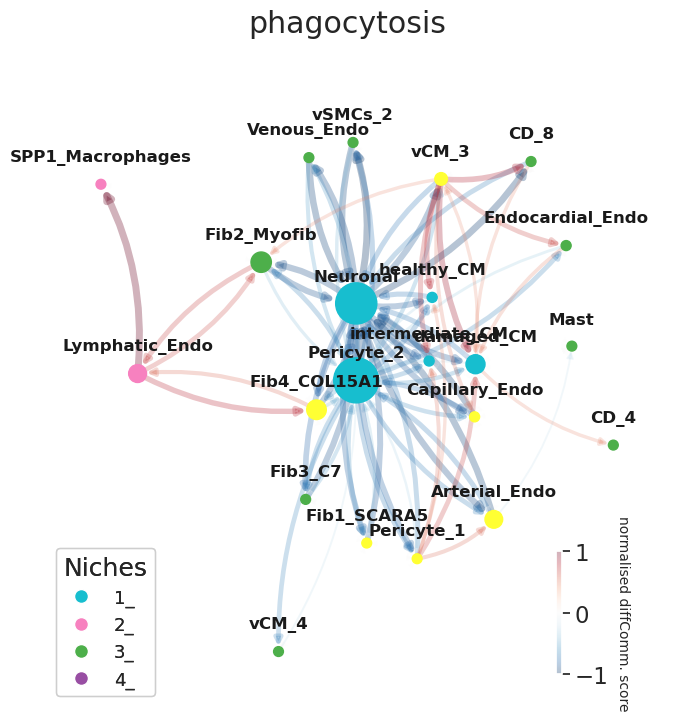

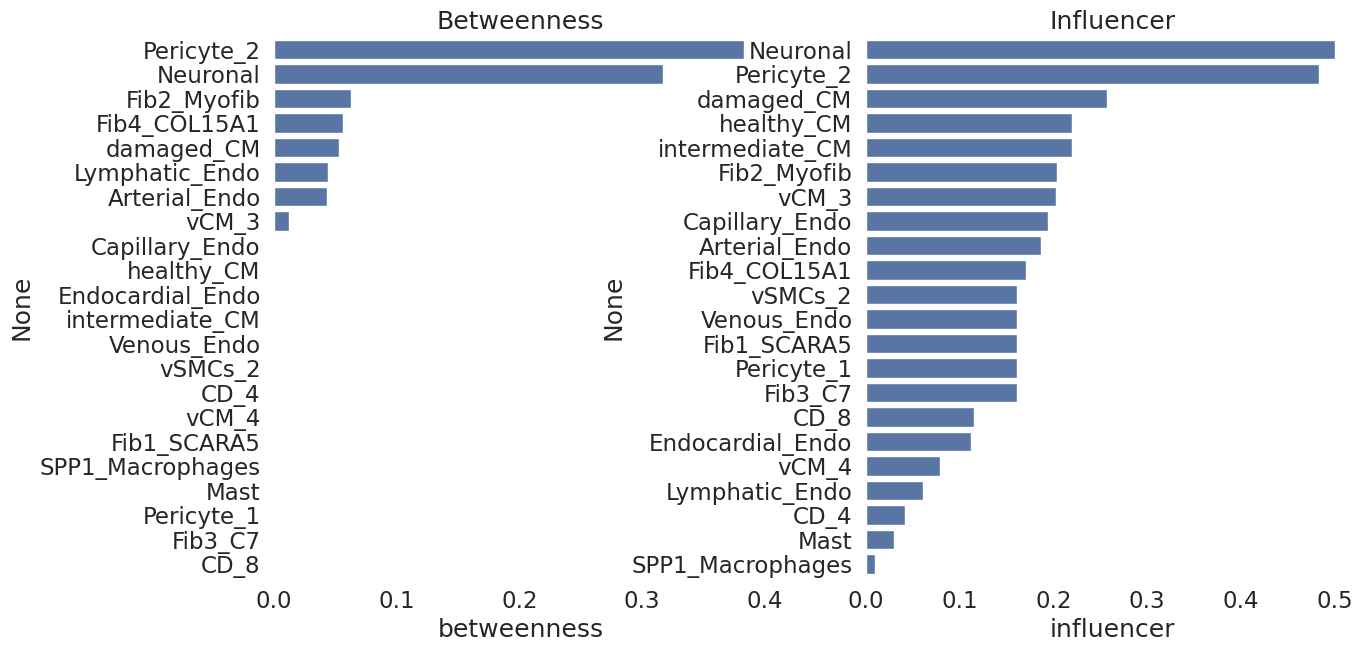

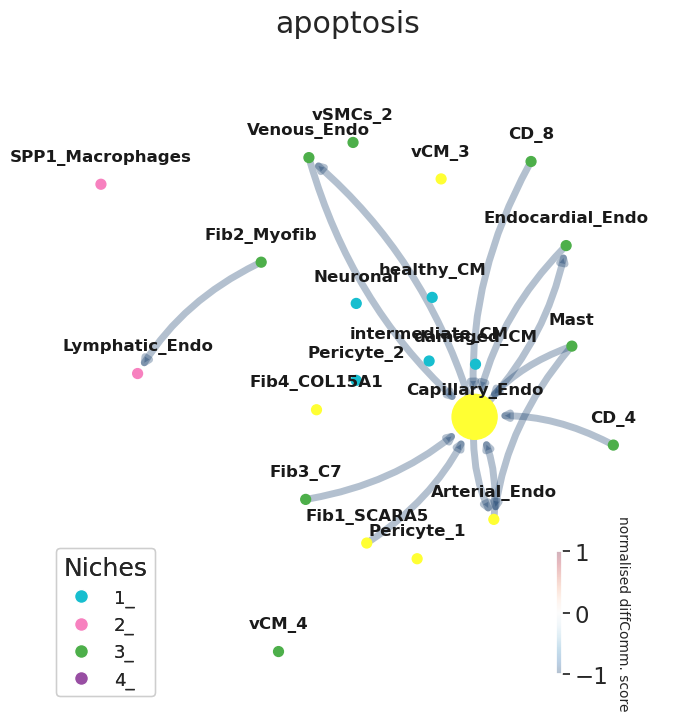

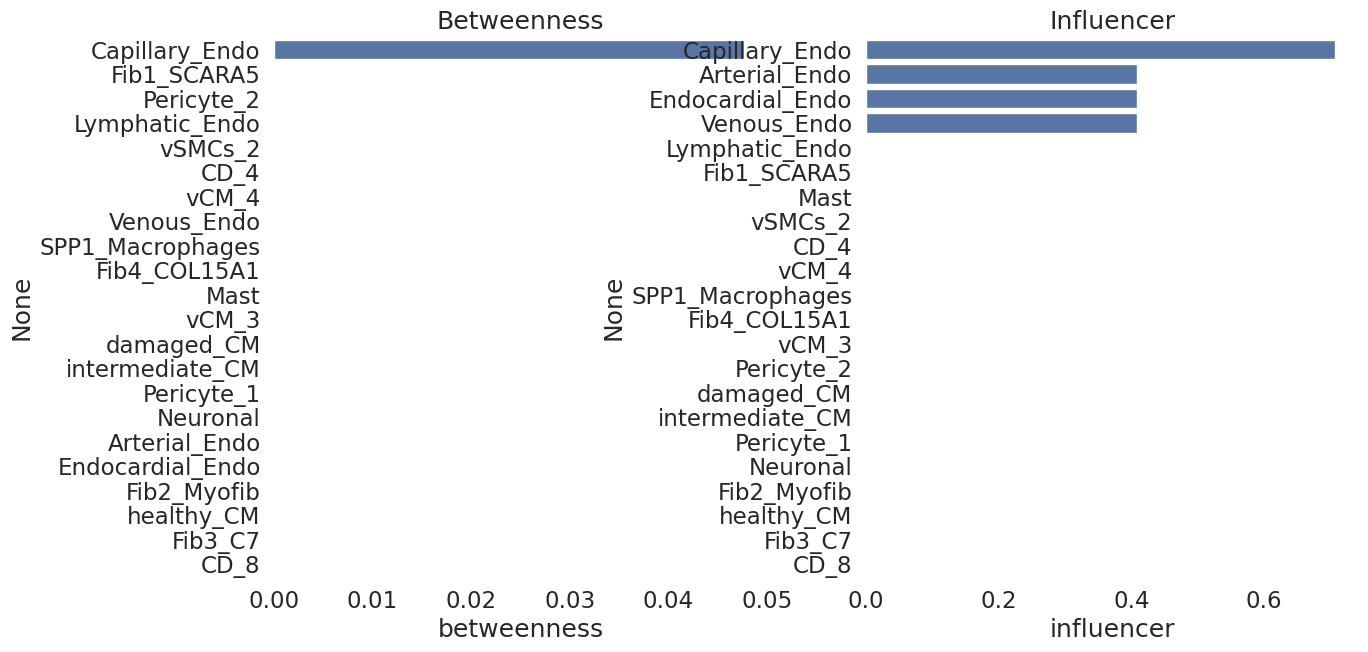

In [65]:
## Differential NWs 
plt.rcParams['axes.facecolor'] = "None"
plt.figure(frameon=False)
### Just one ligand category at a time
for cat in ['ECMglycoprots', 'ECMaffiliated', 'SecretedFactors', 'Cytokine', 'Collagens', 'phagocytosis', 'apoptosis']:
    #we will first get a matrix of differential communication scores (x_chem) from a selected ligand category and the corresponding adjacency matrix (adjChem) 
    x_chem,adjChem=nichesphere.tl.getAdj_comm(diffCommTbl=x_myoIsc_dir, pairCatDF=pairCatDFdir, ncells=33, cat=cat)
    #Then we can plot the differential communication scores of that category in a heatmap
    #And visualize these ligand-receptor interactions as edges in the co-localization network
    plt.setp(plot.ax_heatmap.yaxis.get_majorticklabels(), rotation=1)
    G=nichesphere.tl.catNW(x_chem=x_chem,colocNW=gCol, cell_group=niches_dict, group_cmap='tab20', ncols=20, plot_title=cat, clist=clist, BTsizedNodes=True)
    legend_elements1 = [plt.Line2D([0], [0], marker="o" ,color='w', markerfacecolor=plt.cm.tab10.colors[9], lw=4, label='1_', ms=10),
                   plt.Line2D([0], [0], marker="o" ,color='w', markerfacecolor=plt.cm.Set1.colors[7], lw=4, label='2_', ms=10),
                   plt.Line2D([0], [0], marker="o" ,color='w', markerfacecolor=plt.cm.Set1.colors[2], lw=4, label='3_', ms=10),
                   plt.Line2D([0], [0], marker="o" ,color='w', markerfacecolor=plt.cm.Set1.colors[3], lw=4, label='4_', ms=10)]

    plt.gca().add_artist(plt.legend(handles=legend_elements1,loc='lower left', fontsize=13, title='Niches', alignment='left'))
    #plt.savefig('../../../../figures_nichesphere_tutorial/colocFilt_commNW_'+cat+'.pdf')
    plt.show()
    
    t1=pd.DataFrame({'betweenness':[nx.betweenness_centrality(G)[x] for x in list(G.nodes)], 'influencer':[nx.eigenvector_centrality(G, max_iter=1000)[x] for x in list(G.nodes)]})
    t1.index=list(G.nodes)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    sns.barplot(ax=axes[0], y=t1.sort_values('betweenness', ascending=False).index, x='betweenness', data=t1.sort_values('betweenness', ascending=False))
    axes[0].set_title('Betweenness')
    
    sns.barplot(ax=axes[1], y=t1.sort_values('influencer', ascending=False).index, x='influencer', data=t1.sort_values('influencer', ascending=False))
    axes[1].set_title('Influencer')
    #plt.savefig('../../../../figures_nichesphere_tutorial/nwStats_'+cat+'.pdf')